В этом блокноте рассматриваются некоторые подходы к задаче машинного перевода с помощью

* Рекуррентных сетей
* Рекуррентных сетей с механизмом внимания
* Трасформеров

Первый и последний подходы уже реализованы. Вам предлагается реализовать второй подход, а именно интегрировать механизм внимания в рекуррентную НС. Для лучшего понимания рекомендуем ознакомиться [со следющей статьей](https://arxiv.org/pdf/1409.0473). Какой конкретно тип механизма внимания реализовывать остается на выбор студенту.

Для оценок трех рассмотренных подходов реализовать метрику BLEU. В качестве тестовой выборки можно использовать валидационный набор. Или произвести требуемое разделение самостоятельно.

В качестве резюме (на 3 балла):

1. Разобраться в задаче и в коде
2. Добавить внимание к рекуррентной сети
3. Реализовать BLEU
4. Сравнить полученные 3 модели между собой.
5. **Опционально (+1 балл)**: продемонстрировать alignment между словами на исходном и целевом языках (аналогично Figure 3 в предложенной статье).
6. **Опционально (+1 балл)**: сравнить 3 полученных модели (по метрике) между собой на парах различной длины. Например, вычислить метрики на коротких, средних и длинных предложениях. Если средних/длинных предложений нет в выборке -- сгенерировать самостоятельно, например через LLM.

# Загрузка данных

In [ ]:
import random
import numpy as np
import string
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.ops as ops
from collections import Counter
import math
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2025-06-05 14:05:19--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.007s  

2025-06-05 14:05:19 (355 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

print(random.choice(text_pairs))

random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

('You missed.', '[start] Fallaste. [end]')


**Векторизация пар**

In [ ]:
# Формируем строку символов, которые будем удалять из текста
# Включаем все знаки пунктуации из string.punctuation и испанский перевернутый вопросительный знак '¿'
strip_chars = string.punctuation + "¿"
# Исключаем квадратные скобки из списка удаляемых символов, чтобы сохранить токены [start] и [end]
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Размер словаря (максимальное количество токенов)
vocab_size = 15000
# Максимальная длина выходной последовательности
sequence_length = 20

# Создаем слой векторизации для исходного языка (английский)
source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",                # Вывод — последовательность индексов токенов
    output_sequence_length=sequence_length,
)

# Функция кастомной стандартизации текста для слоя TextVectorization
def custom_standardization(input_string):
    # К нижнему регистр
    lowercase = tf.strings.lower(input_string)
    # Удаляем все символы с помощью регулярного выражения
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

# Создаем слой векторизации для целевого языка (испанский)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,  # +1 для сдвига в декодере (teacher forcing)
    standardize=custom_standardization,          # Применяем кастомную очистку текста
)

# Извлекаем списки предложений для обучения из пар (английский, испанский)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

# "Обучаем" слой векторизации на текстах, чтобы построить словарь
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

**Подготовка датасетов**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


In [ ]:
def decode_sequence(input_sentence, model, target_vector, source_vector):
    spa_vocab = target_vector.get_vocabulary()
    spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
    max_decoded_sentence_length = 20
    tokenized_input_sentence = source_vector([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vector([decoded_sentence])
        next_token_predictions = model.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# RNN сеть

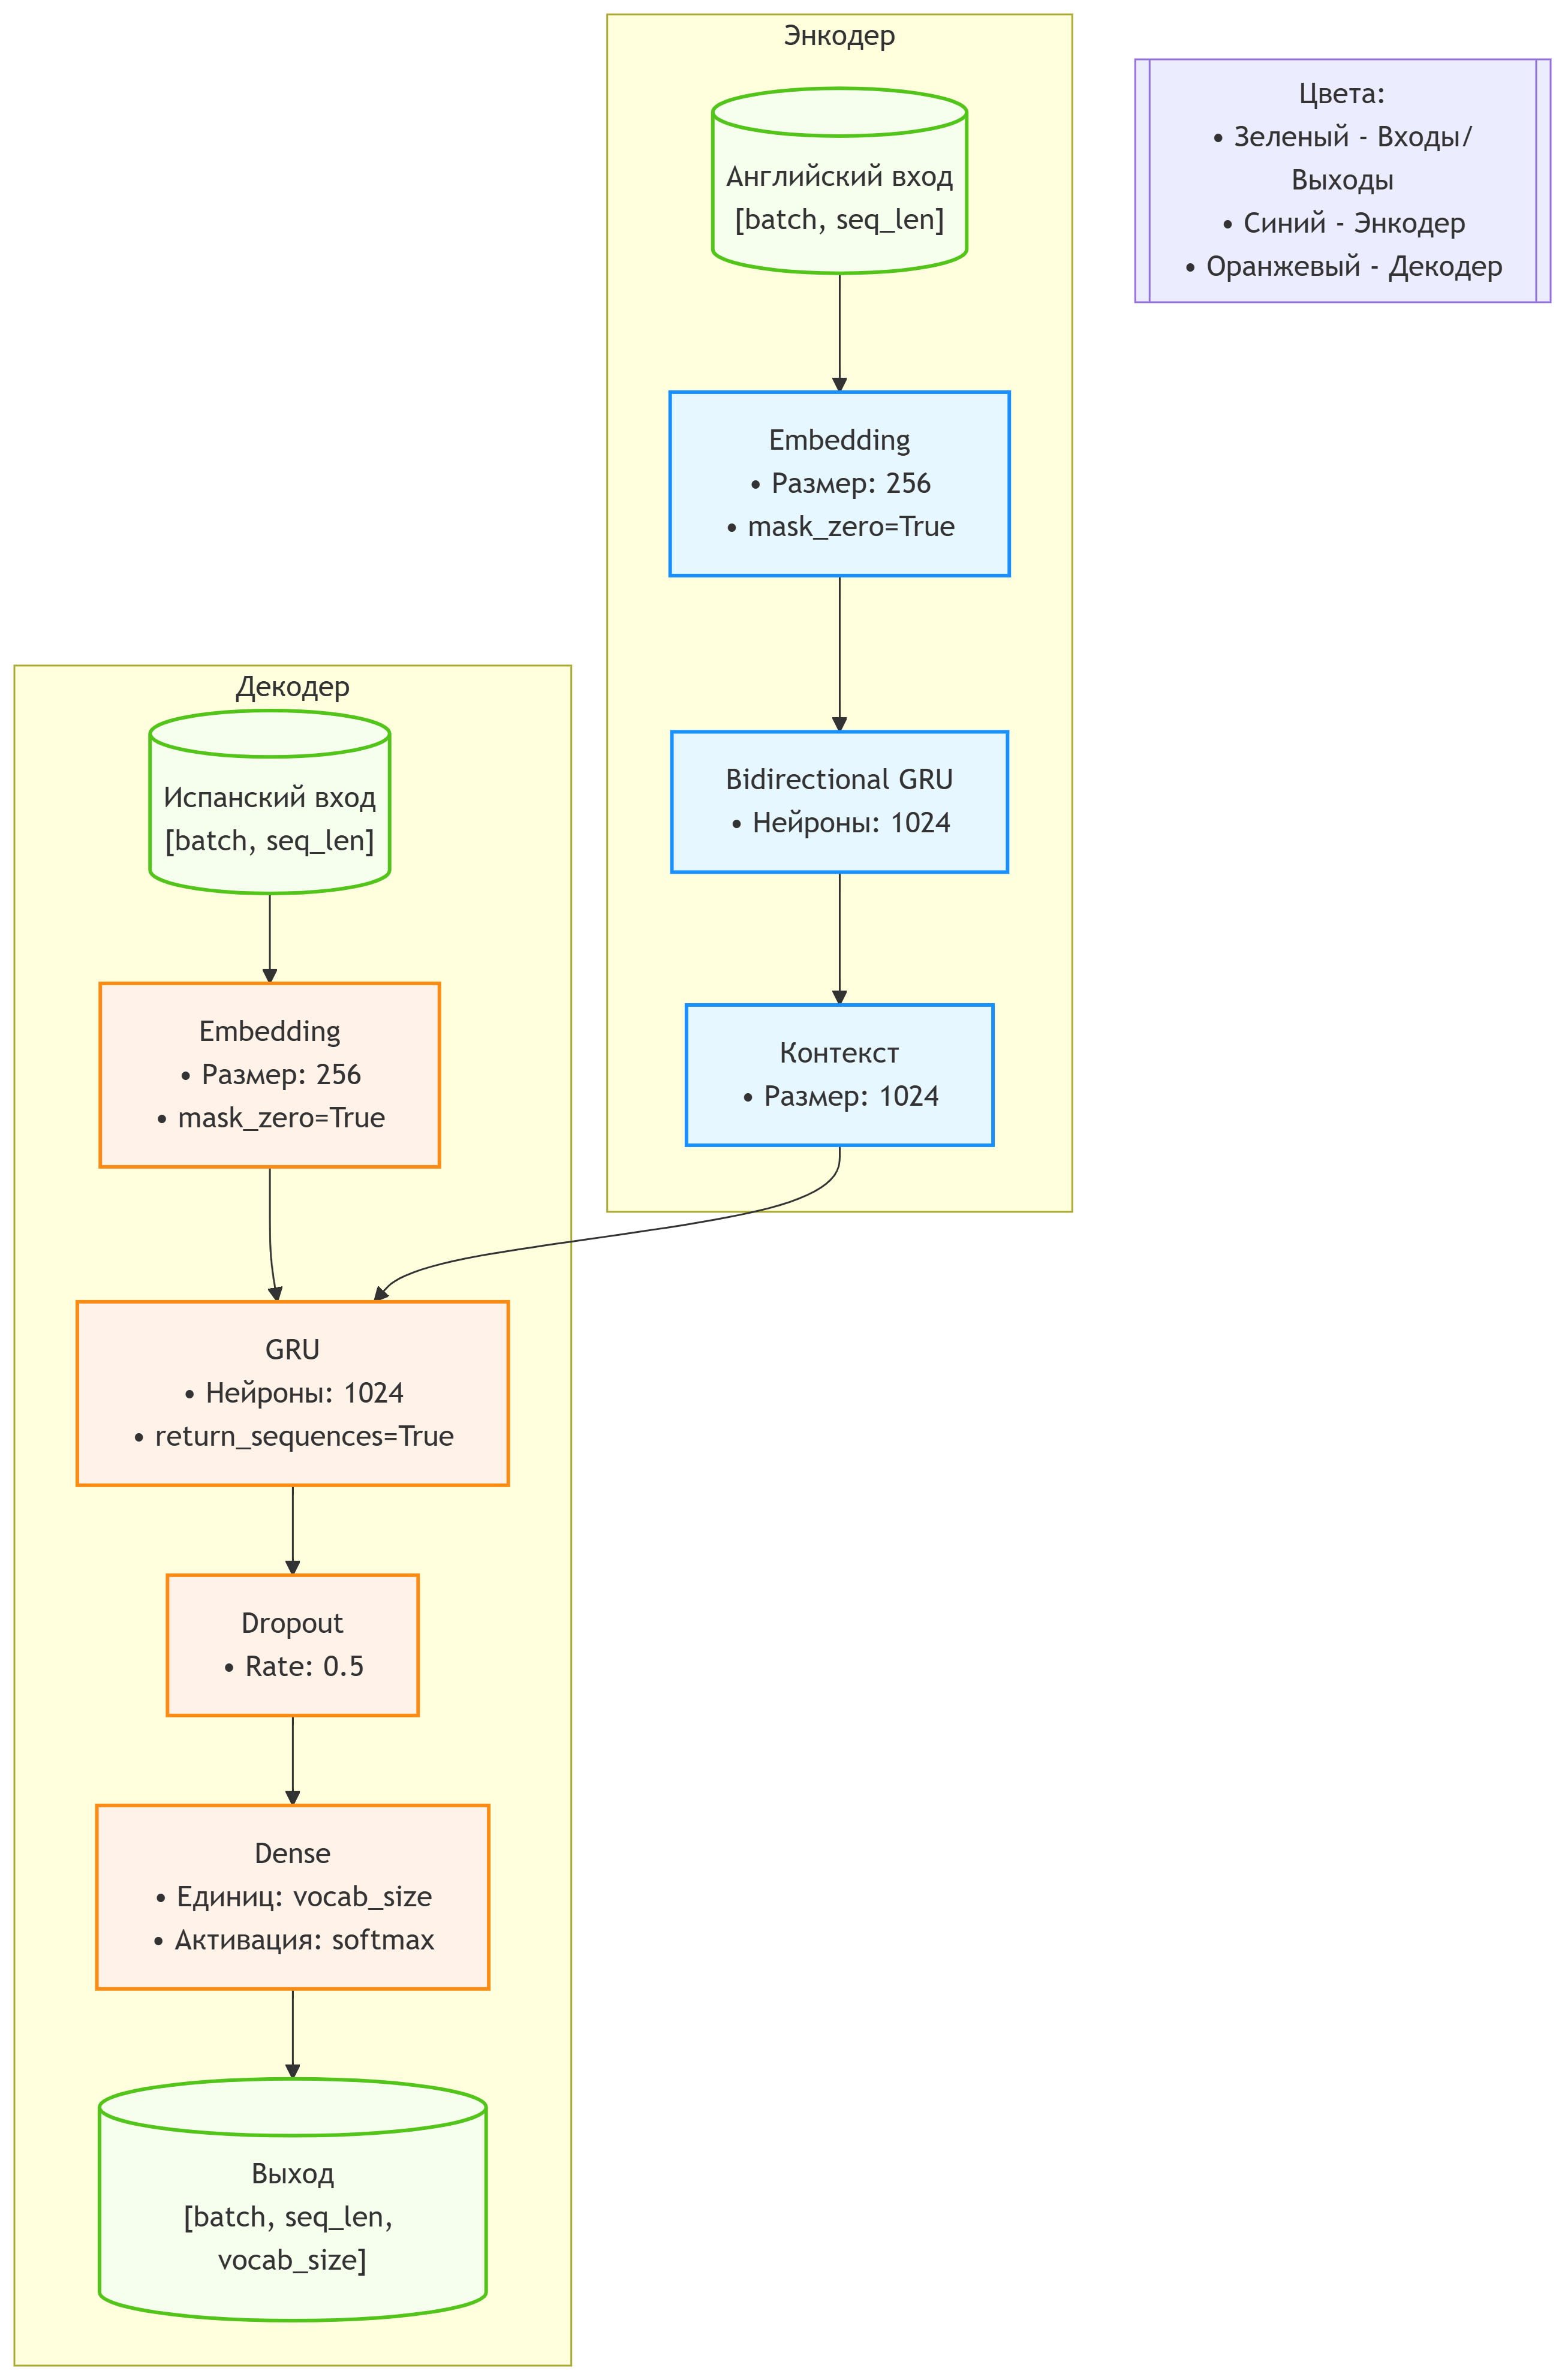

In [ ]:
embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)


seq2seq_rnn = keras.Model([source, past_target], target_next_step)
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 212s 161ms/step - accuracy: 0.1538 - loss: 5.2600 - val_accuracy: 0.1543 - val_loss: 3.9108
Epoch 2/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 208s 160ms/step - accuracy: 0.1600 - loss: 3.8839 - val_accuracy: 0.1887 - val_loss: 3.2372
Epoch 3/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 208s 160ms/step - accuracy: 0.1863 - loss: 3.3087 - val_accuracy: 0.2098 - val_loss: 2.8611
Epoch 4/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 208s 160ms/step - accuracy: 0.2036 - loss: 2.9351 - val_accuracy: 0.2234 - val_loss: 2.6178
Epoch 5/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 209s 160ms/step - accuracy: 0.2173 - loss: 2.6510 - val_accuracy: 0.2337 - val_loss: 2.4401


## **Пример перевода с помощью RNN сети**

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence, seq2seq_rnn, target_vectorization, source_vectorization))

# RNN + attention

In [ ]:
tf.config.run_functions_eagerly(True)

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim, return_sequences=True), merge_mode="sum")(x)

@tf.function
def attention_layer(inputs):
    encoder_output, decoder_output = inputs
    score = layers.dot([decoder_output, encoder_output], axes=[2, 2])
    attention_weights = layers.Activation('softmax', name='attention_weights')(score)
    context_vector = layers.dot([attention_weights, encoder_output], axes=[2, 1])
    return context_vector

past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True, return_state=True)
decoder_output, state_h = decoder_gru(x)

context_vector = attention_layer([encoded_source, decoder_output])
decoder_combined_context = layers.concatenate([context_vector, decoder_output])

x = layers.Dropout(0.5)(decoder_combined_context)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)

seq2seq_rnn_with_attention = keras.Model([source, past_target], target_next_step)
seq2seq_rnn_with_attention.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

seq2seq_rnn_with_attention.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 493s 375ms/step - accuracy: 0.6941 - loss: 3.0138 - val_accuracy: 0.7384 - val_loss: 1.7043
Epoch 2/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 482s 371ms/step - accuracy: 0.7404 - loss: 1.7008 - val_accuracy: 0.7584 - val_loss: 1.5027
Epoch 3/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 495s 380ms/step - accuracy: 0.7594 - loss: 1.5019 - val_accuracy: 0.7766 - val_loss: 1.3313
Epoch 4/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 487s 374ms/step - accuracy: 0.7741 - loss: 1.3536 - val_accuracy: 0.7898 - val_loss: 1.2109
Epoch 5/5
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 503s 374ms/step - accuracy: 0.7858 - loss: 1.2304 - val_accuracy: 0.8016 - val_loss: 1.1209


## **Пример перевода с помощью RNN сети + attention**

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence, seq2seq_rnn_with_attention, target_vectorization, source_vectorization))

-
I fainted from the heat, and when I came to, I was in a life raft.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[start] me he visto a la cama en la que estaba en la cama y la vi [end]
-
What about having fish for dinner?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━

# Трансформер

## **TransformerDecoder**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

## **PositionalEmbedding**

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

## **TransformerEncoder**

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8


encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## **Обучение**

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
 703/1302 ━━━━━━━━━━━━━━━━━━━━ 3:59 400ms/step - accuracy: 0.1434 - loss: 4.9115

KeyboardInterrupt: 

## **Пример перевода Transformer**

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence, transformer, target_vectorization, source_vectorization))

-
Tom is a very clever man.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[start] tom es un hombre muy inteligente [end]
-
You almost hit me.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[start] casi me [UNK] [end]
-
Are you going to buy a dictionary?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[start] vas a comprarte un diccionario [end]
-
We need some money.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/

# Оценка моделей

## Реализация BLEU

In [ ]:
def get_ngrams(seq, n):
    return [tuple(seq[i:i+n]) for i in range(len(seq)-n+1)]

def modified_precision(candidate, references, n):
    c_ngrams = get_ngrams(candidate, n)
    if not c_ngrams:
        return 0.0

    max_ref_counts = Counter()
    for ref in references:
        ref_counts = Counter(get_ngrams(ref, n))
        for ngram in ref_counts:
            max_ref_counts[ngram] = max(max_ref_counts[ngram], ref_counts[ngram])

    cand_counts = Counter(c_ngrams)
    clipped = sum(min(cand_counts[ng], max_ref_counts[ng]) for ng in cand_counts)
    return clipped / len(c_ngrams)

def brevity_penalty(candidate, references):
    c_len = len(candidate)
    ref_lens = [len(r) for r in references]
    closest_ref_len = min(ref_lens, key=lambda x: abs(x - c_len))
    if c_len == 0:
        return 0.0
    if c_len > closest_ref_len:
        return 1.0
    return math.exp(1 - closest_ref_len / c_len)

def bleu(candidate, references, max_n=4):
    weights = [1/max_n] * max_n
    precisions = [modified_precision(candidate, references, n) for n in range(1, max_n+1)]
    if 0 in precisions:
        return 0.0
    score = math.exp(sum(w * math.log(p) for w, p in zip(weights, precisions)))
    return brevity_penalty(candidate, references) * score

In [ ]:
candidate = "a quick brown fox jumps over the lazy dog".split()
references = [
    "the quick brown fox jumps over the lazy dog".split(),
    "a fast brown fox leaps over the sleepy dog".split()
]

score = bleu(candidate, references)
print(f"BLEU score: {score:.4f}")

bleu_score_nltk = sentence_bleu(references, candidate)
print(f'NLTK BLEU score: {bleu_score_nltk:.4f}')

BLEU score: 0.8891
NLTK BLEU score: 0.8891


## Сравнение моделей

In [ ]:
import random
from collections import defaultdict


def evaluate_model_bleu(model, pairs, source_vector, target_vector, max_samples=None):
    scores = []
    if max_samples:
        pairs = random.sample(pairs, min(max_samples, len(pairs)))

    for eng, spa in pairs:
        decoded = decode_sequence(eng, model, target_vector, source_vector)

        decoded_words = decoded.replace("[start]", "").replace("[end]", "").strip().split()
        reference_words = spa.replace("[start]", "").replace("[end]", "").strip().split()
        smooth = SmoothingFunction().method1
        score = sentence_bleu([reference_words], decoded_words, smoothing_function=smooth)
        scores.append(score)

    return np.mean(scores)


def split_by_length(pairs):
    short_pairs = []
    medium_pairs = []
    long_pairs = []

    for eng, spa in pairs:
        length = len(eng.split())
        if length < 5:
            short_pairs.append((eng, spa))
        elif 5 <= length <= 10:
            medium_pairs.append((eng, spa))
        else:
            long_pairs.append((eng, spa))

    return short_pairs, medium_pairs, long_pairs


def compare_models(models, model_names, test_pairs, source_vector, target_vector, num_samples=10):
    short_pairs, medium_pairs, long_pairs = split_by_length(test_pairs)

    results = defaultdict(dict)

    for (name, model) in zip(model_names, models):
        short_bleu = evaluate_model_bleu(model, short_pairs[:num_samples],
                                        source_vector, target_vector)
        results[name]['short'] = short_bleu

        medium_bleu = evaluate_model_bleu(model, medium_pairs[:num_samples],
                                         source_vector, target_vector)
        results[name]['medium'] = medium_bleu

        long_bleu = evaluate_model_bleu(model, long_pairs[:num_samples],
                                       source_vector, target_vector)
        results[name]['long'] = long_bleu

    return results



models = [seq2seq_rnn, seq2seq_rnn_with_attention, transformer]
model_names = ['Seq2Seq RNN', 'RNN attention', 'Transformer']

comparison_results = compare_models(models, model_names, test_pairs,
                                  source_vectorization, target_vectorization)

In [ ]:
print("{:<15} {:<10} {:<10} {:<10}".format('Model', 'Short', 'Medium', 'Long'))
for name in model_names:
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        name,
        comparison_results[name]['short'],
        comparison_results[name]['medium'],
        comparison_results[name]['long']
    ))

Model           Short      Medium     Long      
Seq2Seq RNN     0.0973     0.0329     0.0336    
RNN attention   0.0500     0.0383     0.0269    
Transformer     0.1058     0.1242     0.2100    
